In [1]:
# correlate DWE (2021) and Bundestagswahl (2021)

In [2]:
# module imports
import pandas as pd
import statsmodels.api as sm
import scipy
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from ipynb.fs.full.custom_functions import plot_correlation_matrices, plot_2d_density, plot_residuals

In [3]:
# load DWE data into pandas dataframe
dwe_raw = pd.read_csv("data/Abstimmung_DWE.csv")

In [4]:
# clean data
# rename fields to conform with the other plebiscites
dwe_raw["Stimmbezirk"] = dwe_raw["Wahlbezirk"]
dwe_raw["stimmberechtigte_insgesamt"] = dwe_raw["Wahlberechtigte insgesamt"]
dwe_raw["JA"] = dwe_raw["Stimmabgabe Volksentscheid: Ja"]
dwe_raw["NEIN"] = dwe_raw["Stimmabgabe Volksentscheid: Nein"]
dwe_raw["gültige_stimmen"] = dwe_raw["Gültige Stimmen"]
dwe_raw["anteil_ja_dwe"] = dwe_raw["JA"] / dwe_raw["gültige_stimmen"]
dwe_raw["participation_dwe"] = dwe_raw["gültige_stimmen"] / dwe_raw["stimmberechtigte_insgesamt"]
# create unique district ID by concatenating "Bezirksnummer" and "Stimmberzirk"
dwe_raw["unique_district"] = dwe_raw["Bezirksnummer"].map(str) + dwe_raw["Stimmbezirk"].map(str)
# drop all fields but the necessary ones
dwe = dwe_raw.filter(['unique_district', 'anteil_ja_dwe', 'participation_dwe'], axis=1)

In [5]:
# load Bundestagswahl 2021 into dataframe
btw21_raw = pd.read_csv("data/Bundestag_2021.csv")
# create unique district ID by concatenating "Bezirksnummer" and "Stimmberzirk"
btw21_raw["unique_district"] = btw21_raw["Bezirksnummer"].map(str) + btw21_raw["Wahlbezirk"].map(str)
# calculate percentages for all parties
btw21_raw["linke_prozent"] = btw21_raw["DIE LINKE"] / btw21_raw["Gültige Stimmen"]
btw21_raw["grüne_prozent"] = btw21_raw["GRÜNE"] / btw21_raw["Gültige Stimmen"]
btw21_raw["spd_prozent"] = btw21_raw["SPD"] / btw21_raw["Gültige Stimmen"]
btw21_raw["cdu_prozent"] = btw21_raw["CDU"] / btw21_raw["Gültige Stimmen"]
btw21_raw["fdp_prozent"] = btw21_raw["FDP"] / btw21_raw["Gültige Stimmen"]
btw21_raw["afd_prozent"] = btw21_raw["AfD"] / btw21_raw["Gültige Stimmen"]
btw21_raw["OstWest_color"] = np.where(btw21_raw["OstWest"] == "O", 'red', 'blue')
btw21_raw["OstWest_binary"] = np.where(btw21_raw["OstWest"] == "O", 0, 1)

# drop all fields but the necessary ones
btw21 = btw21_raw.filter([
    'unique_district',
    'linke_prozent',
    'grüne_prozent',
    'spd_prozent',
    'fdp_prozent',
    'cdu_prozent',
    'afd_prozent',
    'Bezirksnummer',
    'OstWest_binary',
    'OstWest_color',
], axis=1)
print(btw21)

     unique_district  linke_prozent  grüne_prozent  spd_prozent  fdp_prozent  \
0               1100       0.089320       0.240777     0.168932     0.139806   
1               1101       0.099448       0.295580     0.182320     0.127072   
2               1102       0.146040       0.287129     0.155941     0.106436   
3               1103       0.094512       0.274390     0.149390     0.161585   
4               1104       0.136538       0.323077     0.161538     0.128846   
...              ...            ...            ...          ...          ...   
2252           12622       0.040000       0.155789     0.210526     0.101053   
2253           12623       0.038660       0.213918     0.219072     0.105670   
2254           12624       0.016453       0.148080     0.223035     0.067642   
2255           12625       0.060952       0.144762     0.287619     0.081905   
2256           12626       0.032882       0.158607     0.212766     0.087041   

      cdu_prozent  afd_prozent  Bezirks

In [6]:
# Multiple linear regression for DWE (2021) and Bundestagswahl 2021
# also see: # https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/10_multiple_regression.html

btw_21_merged = btw21.merge(
    dwe,
    how='inner',
    on='unique_district',
)
btw_21_merged = btw_21_merged.dropna()

Y = btw_21_merged['anteil_ja_dwe']
X = btw_21_merged[[
    'linke_prozent',
    'grüne_prozent',
    'spd_prozent',
    'cdu_prozent',
    'fdp_prozent',
    'afd_prozent',
    'participation_dwe',
]]

X = sm.add_constant(X) # adding a constant
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:          anteil_ja_dwe   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     1182.
Date:                Sun, 30 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:42:44   Log-Likelihood:                 3102.7
No. Observations:                2256   AIC:                            -6189.
Df Residuals:                    2248   BIC:                            -6144.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.6356      0.04

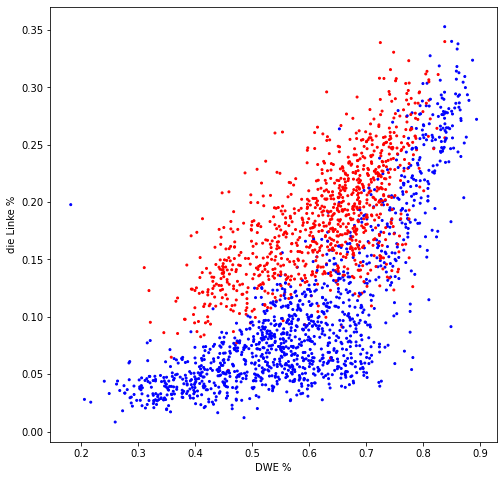

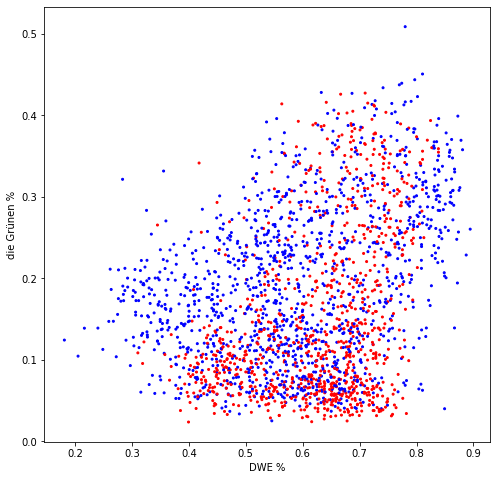

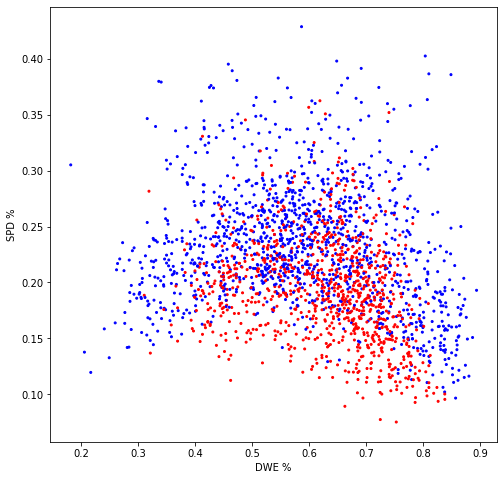

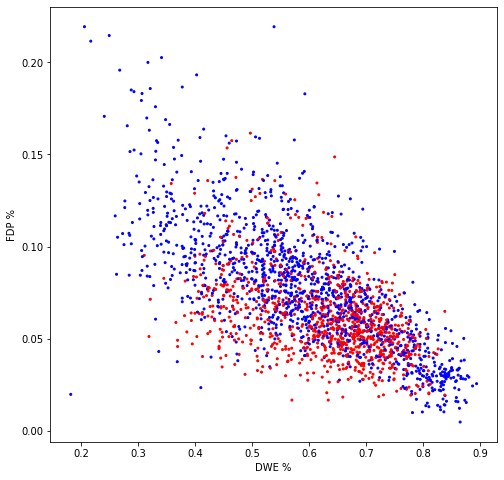

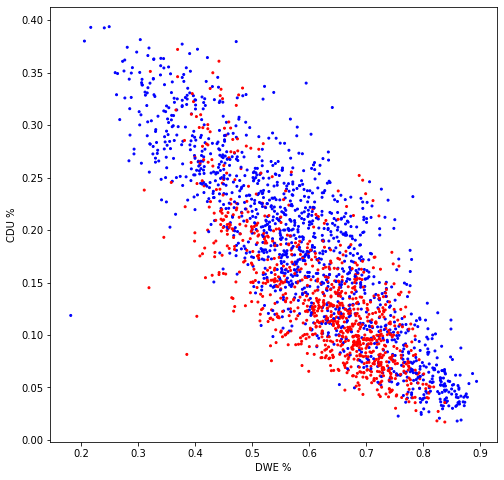

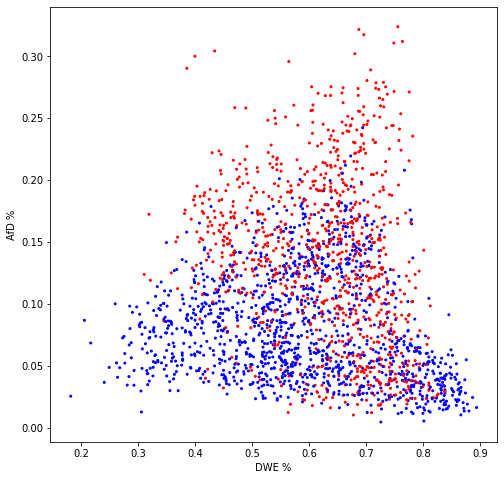

In [7]:
# Scatterplots of all parties vs. DWE individually

party_map = {
    'die Linke %': 'linke_prozent',
    'die Grünen %': 'grüne_prozent',
    'SPD %': 'spd_prozent',
    'FDP %': 'fdp_prozent',
    'CDU %': 'cdu_prozent',
    'AfD %': 'afd_prozent',
}

for party in party_map:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(data=btw_21_merged, x='anteil_ja_dwe', y=party_map[party], c=btw_21_merged["OstWest_color"], s=4)
    ax.set(title='', xlabel='DWE %', ylabel=party)
    plt.show()

   linke_prozent  grüne_prozent  spd_prozent  fdp_prozent  cdu_prozent  \
0       0.089320       0.240777     0.168932     0.139806     0.139806   
1       0.099448       0.295580     0.182320     0.127072     0.151934   
2       0.146040       0.287129     0.155941     0.106436     0.146040   
3       0.094512       0.274390     0.149390     0.161585     0.140244   
4       0.136538       0.323077     0.161538     0.128846     0.113462   

   afd_prozent  anteil_ja_dwe  participation_dwe  
0     0.040777       0.588583           0.313387  
1     0.041436       0.505556           0.377754  
2     0.066832       0.545226           0.310210  
3     0.048780       0.496875           0.316518  
4     0.038462       0.513672           0.400940  


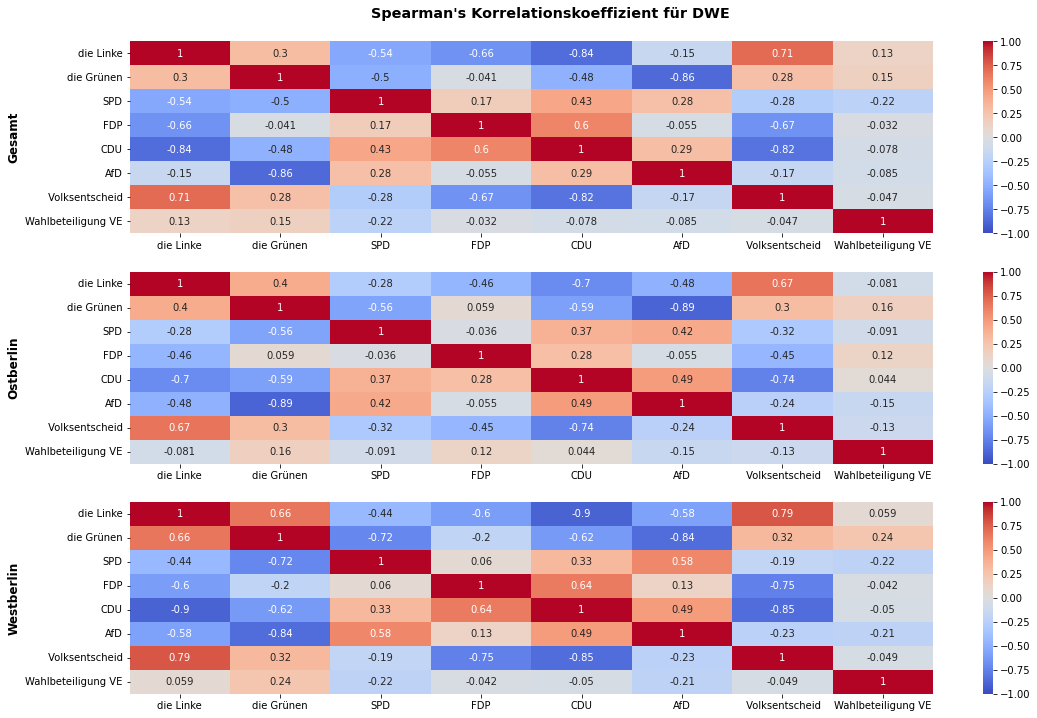

In [8]:
axis_labels = ['die Linke', 'die Grünen', 'SPD', 'FDP', 'CDU', 'AfD', ' Volksentscheid', 'Wahlbeteiligung VE']
plot_correlation_matrices(btw_21_merged, "spearman", "Spearman's", "DWE", axis_labels)

   linke_prozent  grüne_prozent  spd_prozent  fdp_prozent  cdu_prozent  \
0       0.089320       0.240777     0.168932     0.139806     0.139806   
1       0.099448       0.295580     0.182320     0.127072     0.151934   
2       0.146040       0.287129     0.155941     0.106436     0.146040   
3       0.094512       0.274390     0.149390     0.161585     0.140244   
4       0.136538       0.323077     0.161538     0.128846     0.113462   

   afd_prozent  anteil_ja_dwe  participation_dwe  
0     0.040777       0.588583           0.313387  
1     0.041436       0.505556           0.377754  
2     0.066832       0.545226           0.310210  
3     0.048780       0.496875           0.316518  
4     0.038462       0.513672           0.400940  


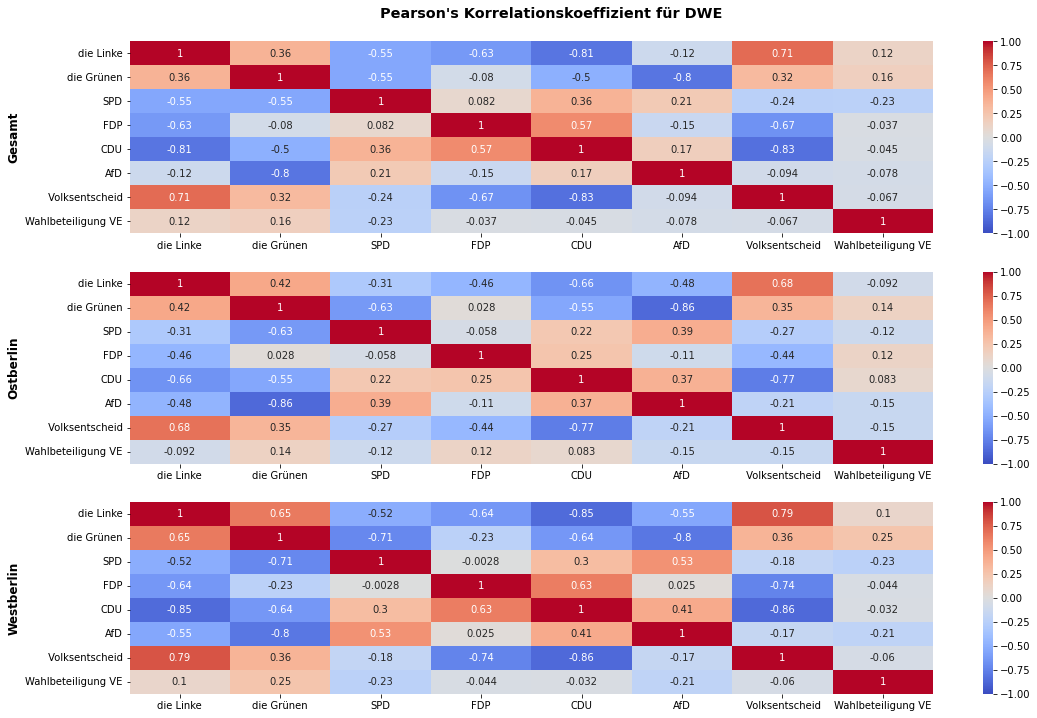

In [9]:
axis_labels = ['die Linke', 'die Grünen', 'SPD', 'FDP', 'CDU', 'AfD', ' Volksentscheid', 'Wahlbeteiligung VE']
plot_correlation_matrices(btw_21_merged, "pearson", "Pearson's", "DWE", axis_labels)

In [10]:
# T-test for significant difference between East and West in DWE and party results

dwe_east = btw_21_merged.loc[btw_21_merged['OstWest_binary'] == 0]
dwe_east = dwe_east.filter([
    'linke_prozent',
    'grüne_prozent',
    'spd_prozent',
    'fdp_prozent',
    'cdu_prozent',
    'afd_prozent',
    'anteil_ja_dwe',
    'participation_dwe',
], axis=1)
dwe_west = btw_21_merged.loc[btw_21_merged['OstWest_binary'] == 1]
dwe_west = dwe_west.filter([
    'linke_prozent',
    'grüne_prozent',
    'spd_prozent',
    'fdp_prozent',
    'cdu_prozent',
    'afd_prozent',
    'anteil_ja_dwe',
    'participation_dwe',
], axis=1)
p_values = scipy.stats.ttest_ind(a=dwe_east, b=dwe_west)[1]

print("p-Werte der T-Tests auf Unterschiede der Grundgesamtheit zwischen Ost- und Westberlin für...")
print("die LINKE: {}".format(p_values[0].round(3)))
print("die Grünen: {}".format(p_values[1].round(3)))
print("SPD: {}".format(p_values[2].round(3)))
print("FDP: {}".format(p_values[3].round(3)))
print("CDU: {}".format(p_values[4].round(3)))
print("AfD: {}".format(p_values[5].round(3)))
print("Zustimmung DWE: {}".format(p_values[6].round(3)))
print("Wahlbeteiligung DWE: {}".format(p_values[7].round(3)))

p-Werte der T-Tests auf Unterschiede der Grundgesamtheit zwischen Ost- und Westberlin für...
die LINKE: 0.0
die Grünen: 0.0
SPD: 0.0
FDP: 0.0
CDU: 0.0
AfD: 0.0
Zustimmung DWE: 0.0
Wahlbeteiligung DWE: 0.0


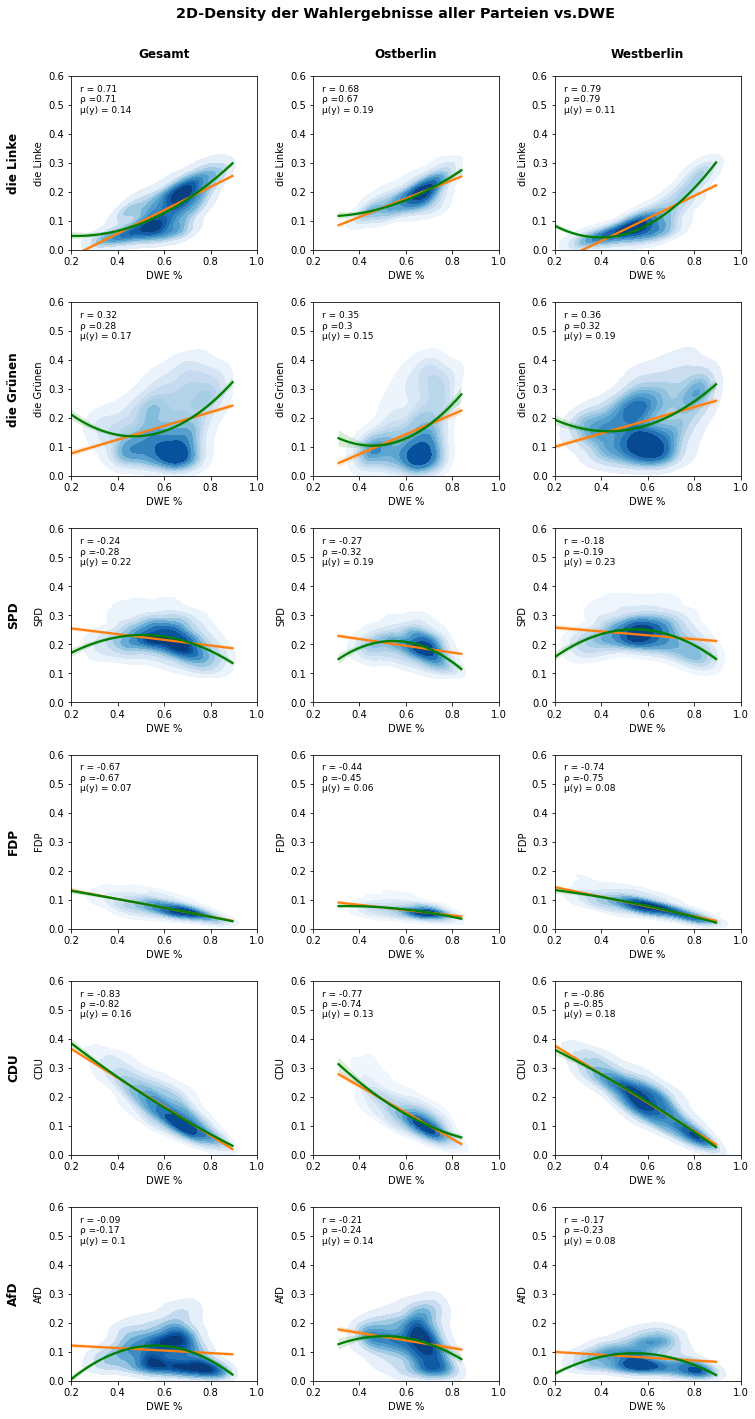

In [11]:
# density plots
dfs = [btw_21_merged, dwe_east, dwe_west]
plot_2d_density('DWE', dfs,  'anteil_ja_dwe', 0.2)

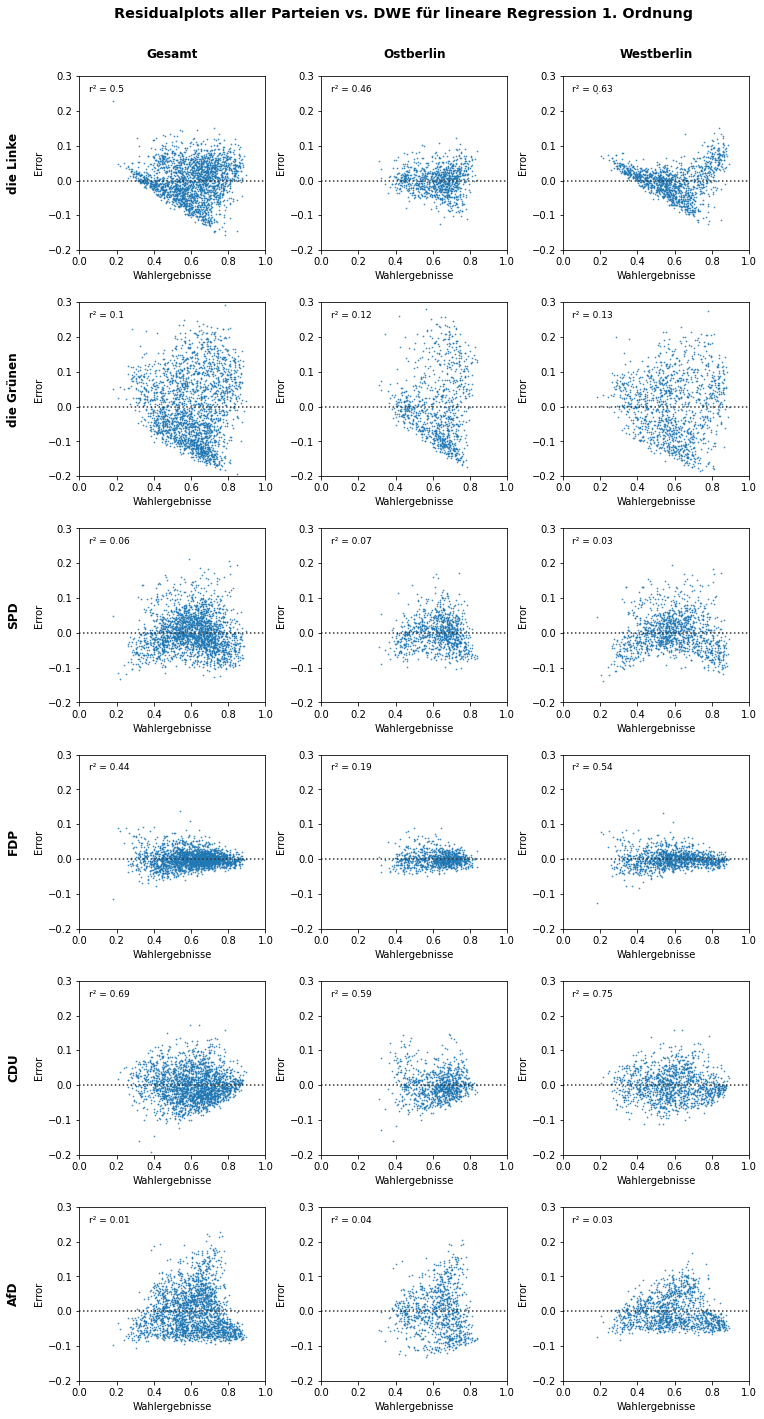

In [12]:
# plot residuals
dfs = [btw_21_merged, dwe_east, dwe_west]
plot_residuals(plebiscite_title='DWE', dfs=dfs, plebiscite_column_name='anteil_ja_dwe', pol_order=1)

In [13]:
# plot residuals
dfs = [btw_21_merged, dwe_east, dwe_west]
plot_residuals(plebiscite_title='DWE', dfs=dfs, plebiscite_column_name='anteil_ja_dwe', pol_order=2)